## Project 2: DATA 620

### by: The p < 0.05 Team - Haig Bedros, Noori Selina, Julia Ferris, Matthew Roland

Tasks: 
1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?


<u>Task 1</u>

The dataset used in this project is titled "affiliations_1996," and the original data is located at the following website: https://github.com/JeffreyAlanSmith/Integrated_Network_Science/blob/master/data/affiliations_1996.txt

In this dataset, each row is a student, and each column is a club. 0 indicates the student is not in the club. 1 indicates the student is in the club. First, the data will be explored for general information. Below, the data is imported as a data frame.


In [2]:
import pandas as pd

# Path to your .tab file
file_path = 'https://raw.githubusercontent.com/juliaDataScience-22/project2-620/main/affiliations_1996.txt'

# Read .tab file into a DataFrame
df = pd.read_csv(file_path, delimiter='\t')
df.reset_index(inplace=True)
df.rename(columns={'index': 'ID'}, inplace=True)

# Display the first few rows of the DataFrame
print(df.head())

# Source: https://github.com/JeffreyAlanSmith/Integrated_Network_Science/blob/master/data/affiliations_1996.txt

       ID  Academic decathalon  Art Club  Asian Club  Band, 8th  Band, Jazz  \
0  101498                    0         0           0          0           0   
1  104452                    0         0           0          0           0   
2  104456                    0         0           0          0           0   
3  104462                    0         0           0          0           0   
4  104471                    0         0           0          0           0   

   Band, Marching (Symphonic)  Baseball, JV (10th)  Baseball, V  \
0                           0                    0            0   
1                           1                    0            0   
2                           0                    0            0   
3                           0                    0            0   
4                           0                    0            0   

   Basketball, boys 8th  ...  Track, girls 8th  Track, girls V  \
0                     0  ...                 0          

Next, the data will be explored.

All the variables are binary, indicating whether or not a student was in a certain club. 91 clubs are included in the dataset. 1,295 students are included in the dataset.

This section checks for missing values. Based on the results, it does not contain any null values.

In [3]:
print(df.isnull().sum())
any_null = df.isnull().any().any()
if any_null:
    print("\nThis data set has null values.")
else:
    print("\nThis data set does not have any null values.")

ID                       0
Academic decathalon      0
Art Club                 0
Asian Club               0
Band, 8th                0
                        ..
Volleyball, V            0
Wrestling, 8th           0
Wrestling, V             0
Yearbook Contributors    0
Yearbook Editors         0
Length: 92, dtype: int64

This data set does not have any null values.


The graphs below show the number of students in each club in descending order.

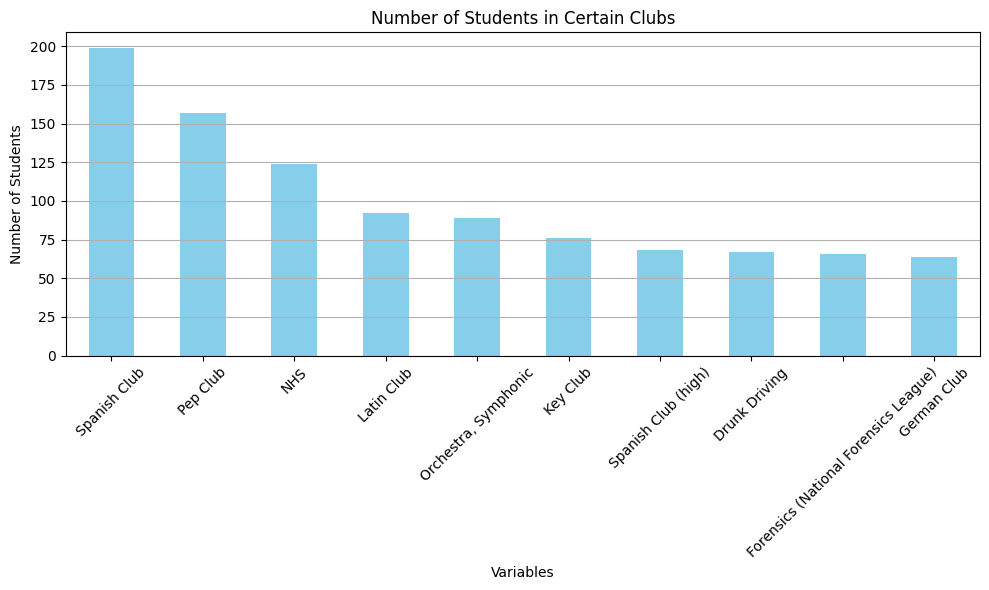

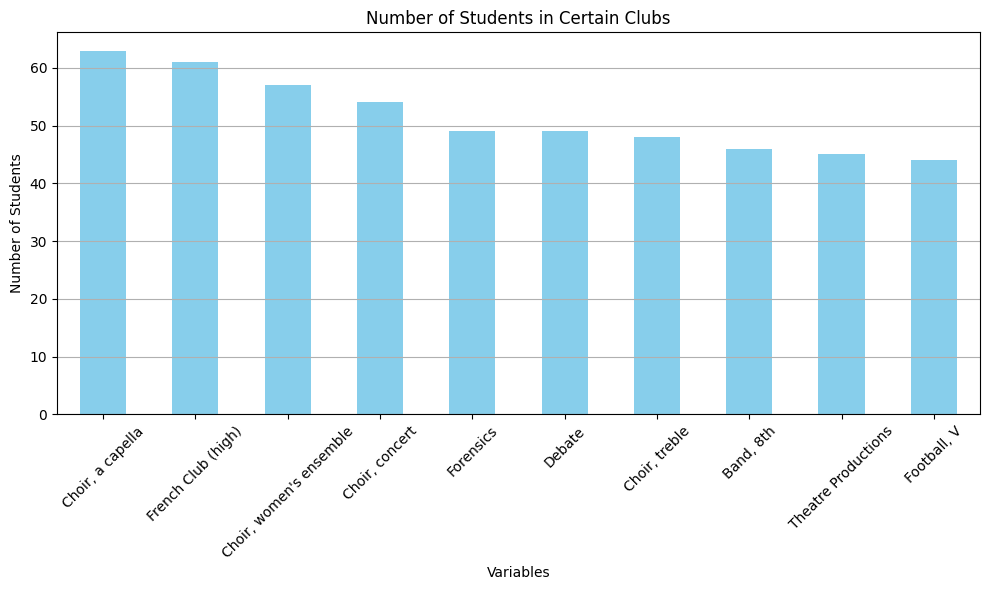

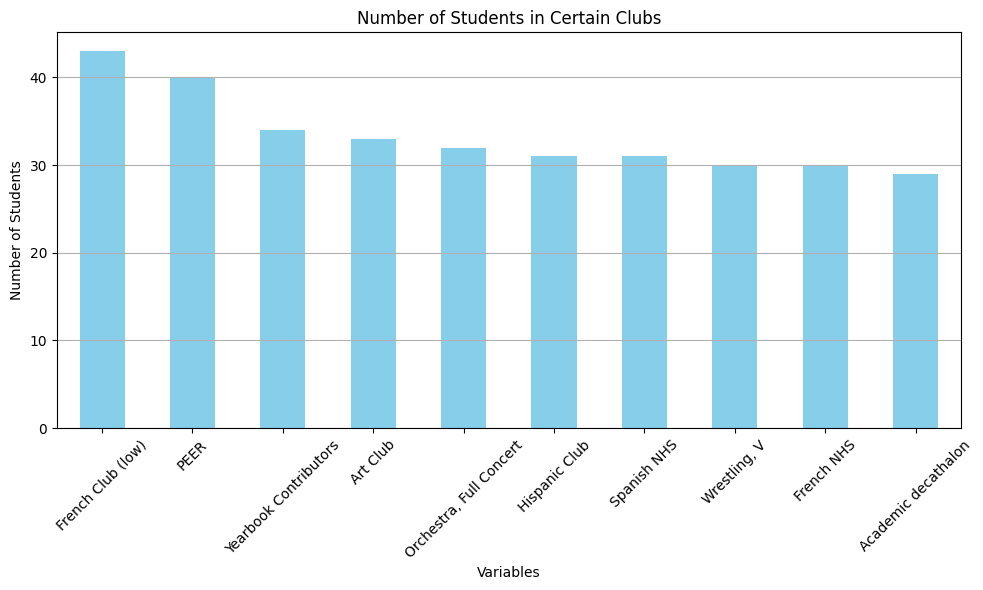

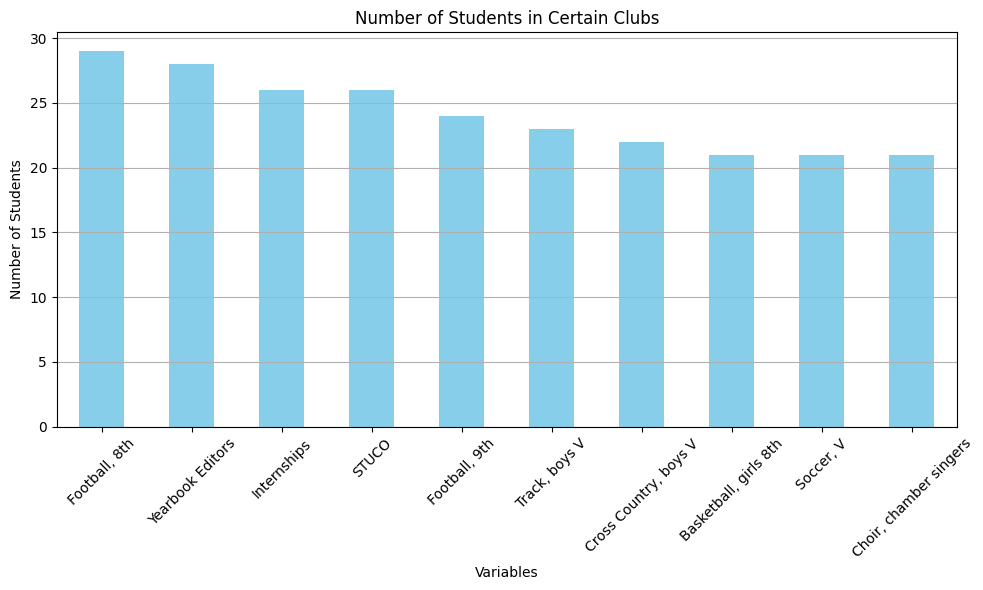

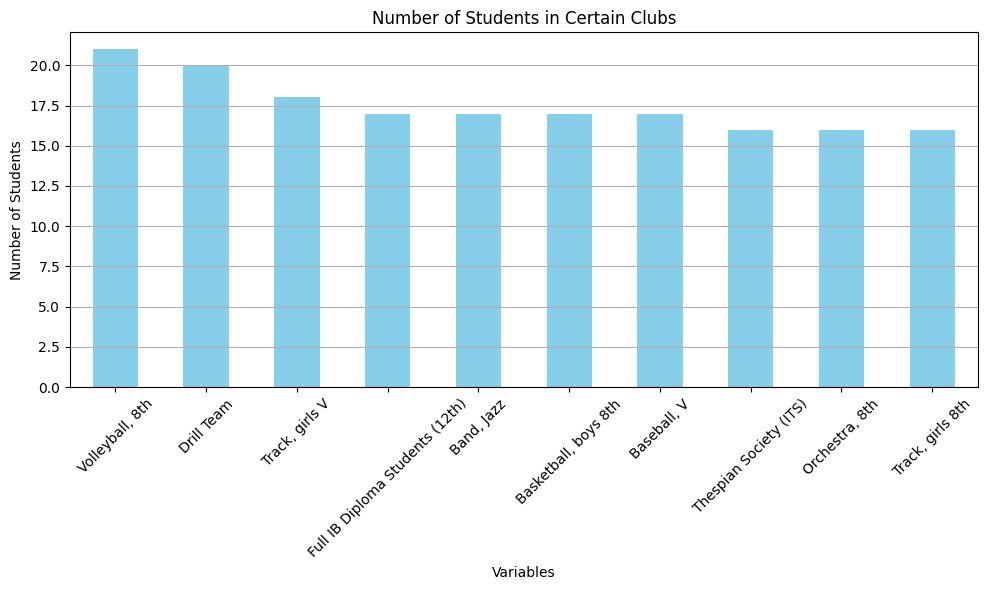

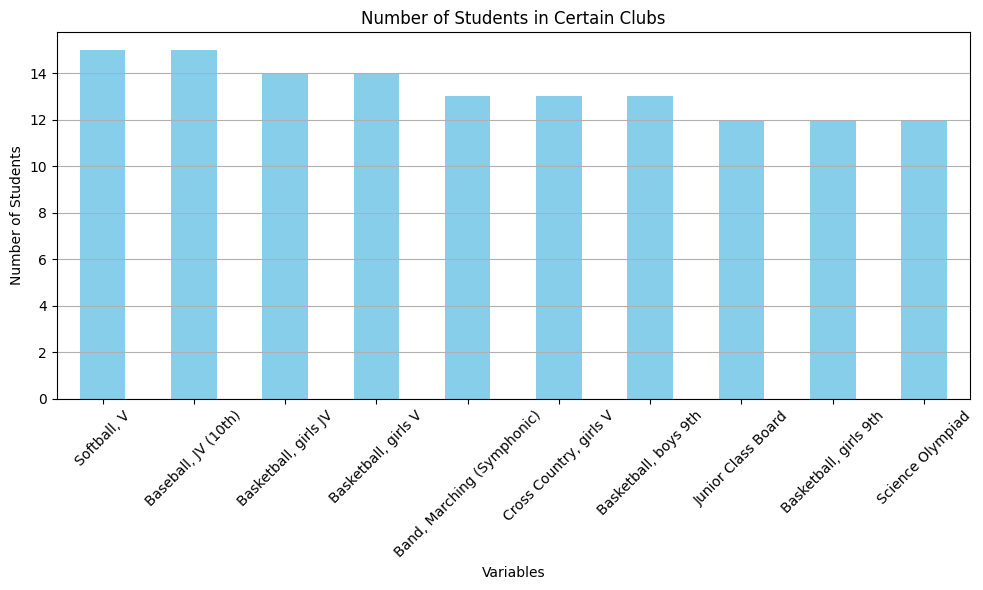

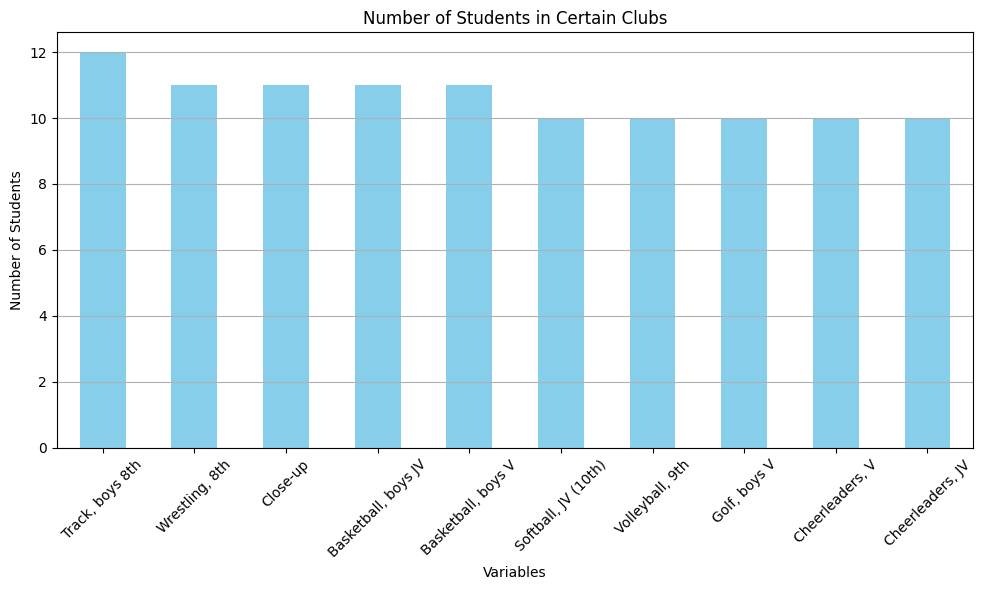

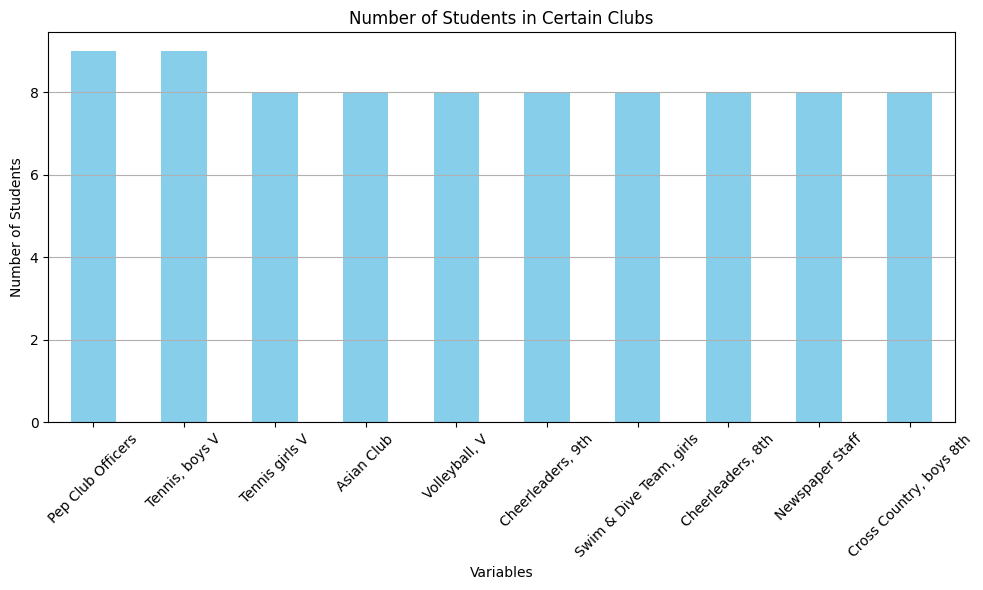

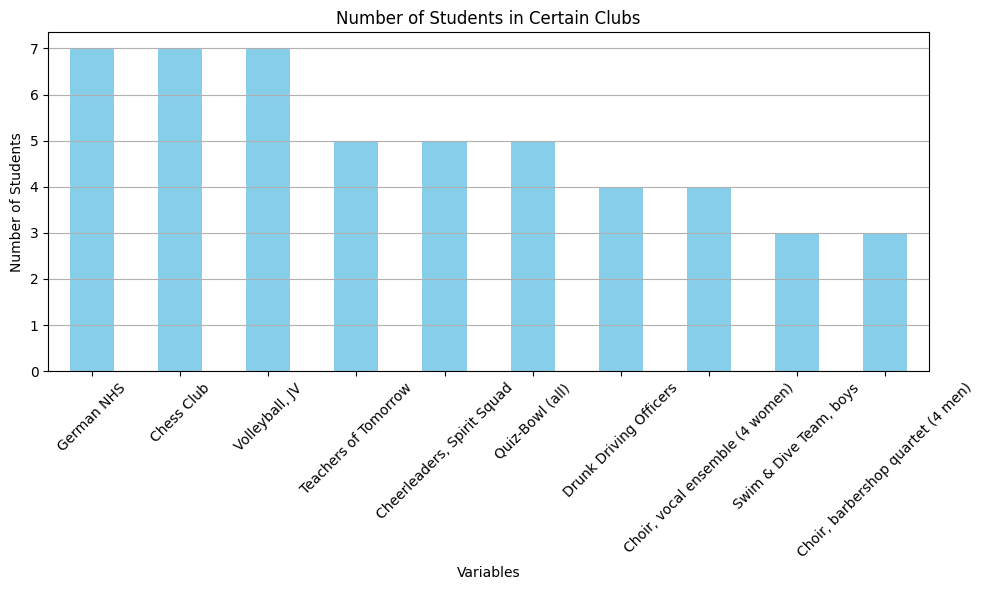

In [4]:
import matplotlib.pyplot as plt

club_counts = df.sum(axis=0)

sorted_clubs = club_counts.sort_values(ascending=False).index

original_df = df

df = df[sorted_clubs]

# Number of variables per chart
variables_per_chart = 10

# Calculate number of charts needed
num_charts = (len(df.columns) - 1) // variables_per_chart
if (len(df.columns) - 1) % variables_per_chart != 0:
    num_charts += 1

# Plotting each group of 10 variables
for i in range(num_charts - 1):
    if(i == 9):
        start_idx = i * variables_per_chart + 1
        end_idx = start_idx + variables_per_chart + 1
        subset_df = df.iloc[:, start_idx:end_idx]
    else:
        start_idx = i * variables_per_chart + 1
        end_idx = start_idx + variables_per_chart
        subset_df = df.iloc[:, start_idx:end_idx]
    
    # Count occurrences of 1 for each subset
    counts = (subset_df == 1).sum()
    
    # Plotting the bar chart
    plt.figure(figsize=(10, 6))  # Adjust figure size if necessary
    counts.plot(kind='bar', color='skyblue')
    plt.title(f'Number of Students in Certain Clubs')
    plt.xlabel('Variables')
    plt.ylabel('Number of Students')
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.grid(axis='y')  # Add grid lines on y-axis
    plt.tight_layout()
    plt.show()


## Interpretation of the Data Overview
### Data Sample

    Columns: Clubs

### Data Information

    Entries: 1,295 students
    Missing Values: No missing values.
    Data Types: All binary values.

### Students Per Club

    The bar graphs show the number of students participating in various clubs in decreasing order of popularity. The x-axis represents different clubs, while the y-axis indicates the number of students in each club. Notably, Spanish Club has the highest membership, followed by the Pep Club and NHS (National Honor Society). The Boys Swim & Dive Team and the Barbershop Quartet Choir have the lowest participation. This distribution highlights the popularity of academic clubs among students.


### Task 2

The network will be shown with all the data first. 

As seen in the image, too many nodes exist for the network to show any meaningful information. All students who do not participate in any clubs form the outer ring. All students who do participate in at least one club form the cluster in the center. 

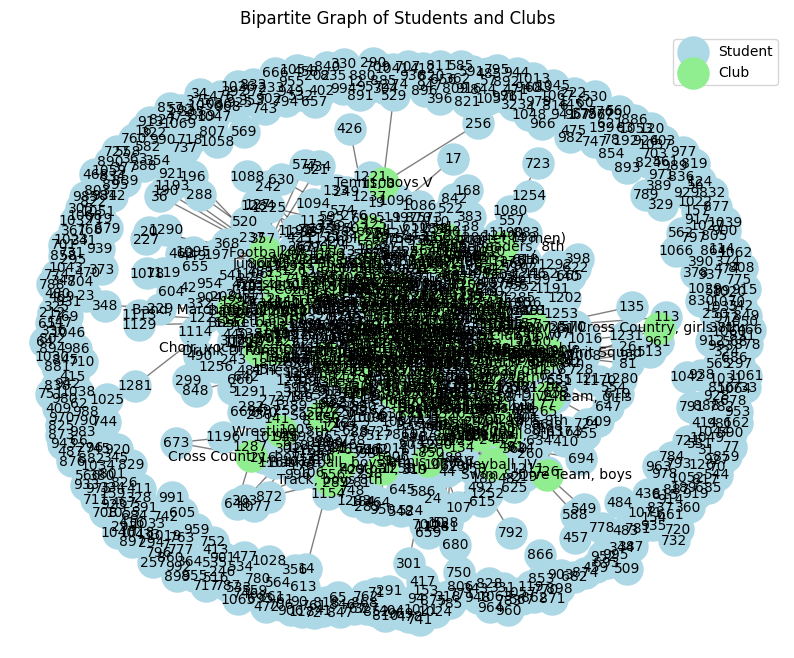

In [11]:
import csv
import math
import networkx as nx

from networkx.algorithms import bipartite as bi

def plot_kid_club_bipartite_graph(data):
    kid_degrees = data.iloc[:, 1:].sum(axis=1)  # Total club memberships per kid
    club_degrees = data.iloc[:, 1:].sum(axis=0)  # Total members per club

    # Get top kids based on degree
    kids = kid_degrees.index.tolist()
    kid_IDs = df.iloc[kids]['ID'].tolist()

    # Get top clubs based on degree
    clubs = club_degrees.index.tolist()

    # Subset data based on top kids and clubs
    ##subset_df = data.loc[data['ID'].isin(kids), ['ID'] + clubs]
    subset_df = data[data['ID'].isin(kid_IDs)][['ID'] + clubs]

    # Create a bipartite graph
    g = nx.Graph()

    # Extract kids and clubs
    ##kids = data['ID'].tolist()
    ##clubs = data.columns[1:].tolist()

    # Add nodes for kids and clubs
    g.add_nodes_from(kids, bipartite=0, type='kid')
    g.add_nodes_from(clubs, bipartite=1, type='club')


    # Add edges between kids and clubs based on membership
    for kid in kid_IDs:
        index = subset_df.index[subset_df['ID'] == kid]
        for club in clubs:
            for i in index:
                if subset_df.loc[i, club] == 1:
                    g.add_edge(i, club)

    # Plotting
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(g, seed=42, k=0.15)

    # Separate nodes by type for visualization
    kid_nodes = [node for node, node_data in g.nodes(data=True) if node_data['type'] == 'kid']
    club_nodes = [node for node, node_data in g.nodes(data=True) if node_data['type'] == 'club']

    # Draw nodes
    nx.draw_networkx_nodes(g, pos, nodelist=kid_nodes, node_color='lightblue', node_size=500, label='Student')
    nx.draw_networkx_nodes(g, pos, nodelist=club_nodes, node_color='lightgreen', node_size=500, label='Club')

    # Draw edges
    nx.draw_networkx_edges(g, pos, width=1.0, alpha=0.5)

    # Draw labels
    nx.draw_networkx_labels(g, pos, font_size=10, font_family='sans-serif')

    # Customization
    plt.title('Bipartite Graph of Students and Clubs')
    plt.axis('off')
    plt.legend()
    plt.show()

# Plotting the bipartite graph of kids and clubs
plot_kid_club_bipartite_graph(df)




Thus, the number of nodes must be reduced. One way to accomplish this is to determine the degrees of each node and only keep nodes of a certain degree. Nodes with the highest degrees are kept, which results in a network of many connections.

In the network below, some of the students are shown as members of multiple clubs. For example, student 447 is a part of Pep Club, Spanish Club, and Symphonic Orchestra.

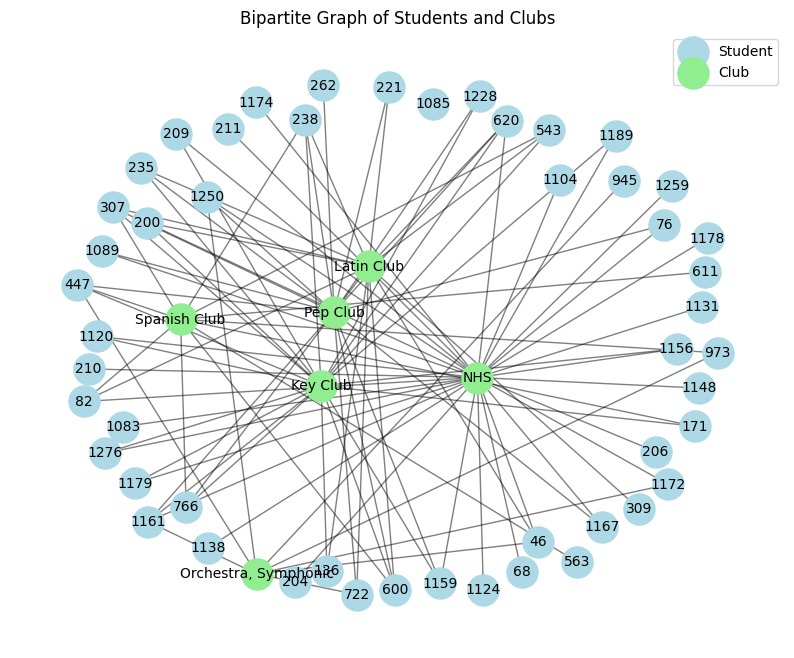

In [9]:
import csv
import math
import networkx as nx

from networkx.algorithms import bipartite as bi

def plot_kid_club_bipartite_graph(data):
    kid_degrees = data.iloc[:, 1:].sum(axis=1)  # Total club memberships per kid
    club_degrees = data.iloc[:, 1:].sum(axis=0)  # Total members per club

    # Get top kids based on degree
    kids = kid_degrees.nlargest(50).index.tolist()
    kid_IDs = df.iloc[kids]['ID'].tolist()

    # Get top clubs based on degree
    clubs = club_degrees.nlargest(6).index.tolist()

    # Subset data based on top kids and clubs
    ##subset_df = data.loc[data['ID'].isin(kids), ['ID'] + clubs]
    subset_df = data[data['ID'].isin(kid_IDs)][['ID'] + clubs]

    # Create a bipartite graph
    g = nx.Graph()

    # Extract kids and clubs
    ##kids = data['ID'].tolist()
    ##clubs = data.columns[1:].tolist()

    # Add nodes for kids and clubs
    g.add_nodes_from(kids, bipartite=0, type='kid')
    g.add_nodes_from(clubs, bipartite=1, type='club')


    # Add edges between kids and clubs based on membership
    for kid in kid_IDs:
        index = subset_df.index[subset_df['ID'] == kid]
        for club in clubs:
            for i in index:
                if subset_df.loc[i, club] == 1:
                    g.add_edge(i, club)
                    

    # Plotting
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(g, seed=42, k = 2)

    # Separate nodes by type for visualization
    kid_nodes = [node for node, node_data in g.nodes(data=True) if node_data['type'] == 'kid']
    club_nodes = [node for node, node_data in g.nodes(data=True) if node_data['type'] == 'club']

    # Draw nodes
    nx.draw_networkx_nodes(g, pos, nodelist=kid_nodes, node_color='lightblue', node_size=500, label='Student')
    nx.draw_networkx_nodes(g, pos, nodelist=club_nodes, node_color='lightgreen', node_size=500, label='Club')

    # Draw edges
    nx.draw_networkx_edges(g, pos, width=1.0, alpha=0.5)

    # Draw labels
    nx.draw_networkx_labels(g, pos, font_size=10, font_family='sans-serif')

    # Customization
    plt.title('Bipartite Graph of Students and Clubs')
    plt.axis('off')
    plt.legend()
    plt.show()

# Plotting the bipartite graph of kids and clubs
plot_kid_club_bipartite_graph(df)




To further analyze this data, the projection below was created. The nodes indicate clubs, and the connections between nodes indicates the number of same student connections. For example, NHS and Spanish club appeared to have the most students in both clubs. The connection was the thickest. Also, German club and Latin club shared some members, but not as many as other clubs.

<Figure size 1000x800 with 0 Axes>

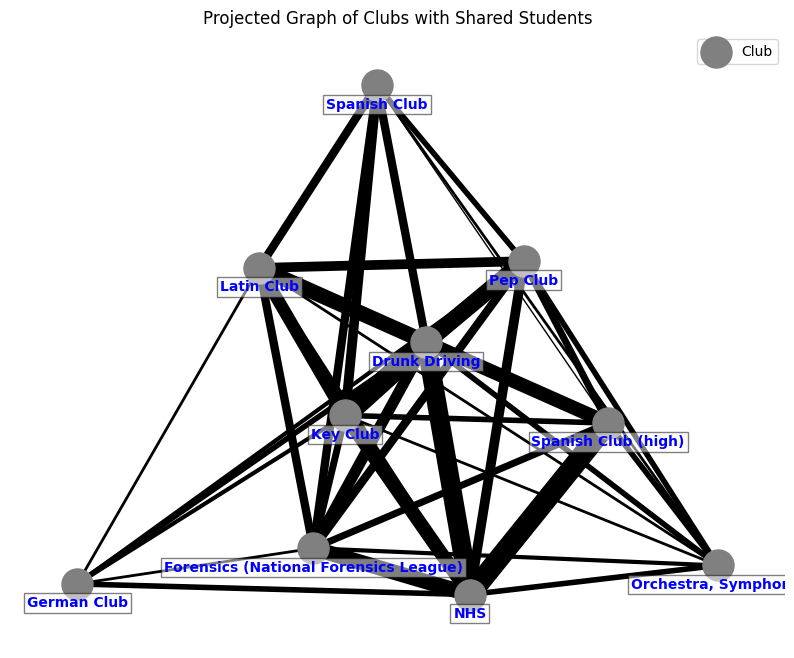

In [28]:

def plot_kid_club_bipartite_graph(data):
    kid_degrees = data.iloc[:, 1:].sum(axis=1)  # Total club memberships per kid
    club_degrees = data.iloc[:, 1:].sum(axis=0)  # Total members per club

    # Get top kids based on degree
    kids = kid_degrees.nlargest(50).index.tolist()
    kid_IDs = data.iloc[kids]['ID'].tolist()

    # Get top clubs based on degree
    clubs = club_degrees.nlargest(10).index.tolist()

    # Subset data based on top kids and clubs
    subset_df = data[data['ID'].isin(kid_IDs)][['ID'] + clubs]

    # Create a bipartite graph
    g = nx.Graph()

    # Add nodes for kids and clubs
    g.add_nodes_from(kid_IDs, bipartite=0, type='kid')
    g.add_nodes_from(clubs, bipartite=1, type='club')

    # Add edges between kids and clubs based on membership
    for kid in kid_IDs:
        index = subset_df.index[subset_df['ID'] == kid]
        for club in clubs:
            for i in index:
                if subset_df.loc[i, club] == 1:
                    g.add_edge(kid, club)

    # Plotting the bipartite graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(g, seed=42, k=2)

    # Separate nodes by type for visualization
    kid_nodes = [node for node, node_data in g.nodes(data=True) if node_data['type'] == 'kid']
    club_nodes = [node for node, node_data in g.nodes(data=True) if node_data['type'] == 'club']


    # Projecting the bipartite graph to a unipartite graph of clubs
    club_graph = bi.weighted_projected_graph(g, clubs)

    # Counting shared students and adding them as edge weights
    for u, v, data in club_graph.edges(data=True):
        shared_students = len(set(g.neighbors(u)) & set(g.neighbors(v)))
        data['weight'] = shared_students

    # Plotting the projected graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(club_graph, seed=42, k=0.15)

    # Draw nodes
    nx.draw_networkx_nodes(club_graph, pos, node_color='gray', node_size=500, label='Club')

    # Draw edges with weights
    edges = club_graph.edges(data=True)
    weights = [data['weight'] for u, v, data in edges]
    nx.draw_networkx_edges(club_graph, pos, edgelist=edges, width=weights)

    # Draw labels
    for p in pos: pos[p][1] -= 0.05
    nx.draw_networkx_labels(club_graph, pos, font_size=10, font_family='sans-serif', font_weight='bold', font_color='blue', bbox={'facecolor': 'white', 'alpha': 0.5, 'edgecolor': 'black', 'pad': 2})

    # Customization
    plt.title('Projected Graph of Clubs with Shared Students')
    plt.axis('off')
    plt.legend()
    plt.show()

# Plotting the bipartite graph of kids and clubs and the projected graph of clubs
plot_kid_club_bipartite_graph(df)


### Task 3

Inferences about distinct groups:
- NHS contains the most students
- Many students in these clubs participate in other clubs
- Students taking symphonic orchestra are likely to also be involved in at least one other club
- Most of the students are likely involved with clubs not in the top 6
- The following clubs showed the most participation of the same students: NHS, Drunk Driving, Spanish, Key Club, Forensics, Latin Club, and Pep Club
- Many of the language and educational clubs are highly connected by student participation

These inferences highlight the diverse interests and high level of extracurricular engagement among students, indicating a vibrant and well-rounded school community.